# Experiment: Piecewise-linear approximation of VNF-PPs (Playground)

Try to represent VNF-PPs as piece-wise linear functions.
The fitting is done using the [pwlf Python library](https://pypi.org/project/pwlf/).

Cite PWLF:

```latex
@Manual{pwlf,
    author = {Jekel, Charles F. and Venter, Gerhard},
    title = {{pwlf:} A Python Library for Fitting 1D Continuous Piecewise Linear Functions},
    year = {2019},
    url = {https://github.com/cjekel/piecewise_linear_fit_py}
}
```


In [321]:
# basics
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import pwlf

## Data Management
Load and clean the data sets to be easily used.

### Load data sets

In [322]:
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys
    of the mapping dict.
    It renames the columns to the values of the
    mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        #print("Renaming: {} -> {}".format(k, v))
        dff.rename(columns={k: v}, inplace=True)
    #print(dff.head())
    return dff

def cleanup(df):
    """
    Cleanup of df data.
    Dataset specific.
    """
    def _replace(df, column, str1, str2):
        if column in df:
            df[column] = df[column].str.replace(str1, str2)
            
    def _to_num(df, column):
        if column in df:
            df[column] = pd.to_numeric(df[column])
        
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/smallFlows.pcap", "0")   
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/bigFlows.pcap", "1")
    _to_num(df, "flow_size")
    _replace(df, "ruleset", "./start.sh small_ruleset", "1")
    _replace(df, "ruleset", "./start.sh big_ruleset", "2")
    _replace(df, "ruleset", "./start.sh", "0")
    _to_num(df, "ruleset")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "1")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "1")
    _to_num(df, "req_size")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 1 --json /tngbench_share/malaria.json", "0")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 2 --json /tngbench_share/malaria.json", "1")
    _replace(df, "req_type", "malaria publish -s 10 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "2")
    _replace(df, "req_type", "malaria publish -s 10000 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "3")
    _to_num(df, "req_type")
    
df_sec01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec01/data/csv_experiments.csv")
df_sec02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec02/data/csv_experiments.csv")
df_sec03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec03/data/csv_experiments.csv")
df_web01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web01/data/csv_experiments.csv")
df_web02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web02/data/csv_experiments.csv")
df_web03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web03/data/csv_experiments.csv")
df_iot01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot01/data/csv_experiments.csv")
df_iot02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot02/data/csv_experiments.csv")

# do renaming and selection
map_sec01 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-suricata.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-suricata.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-suricata.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__suricata_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__suricata_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__suricata_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__suricata_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec02 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort2.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort2.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort2.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__snort_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__snort_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__snort_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__snort_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec03 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort3.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort3.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort3.0.1__mem_max": "memory",
    #"metric__vnf0.vdu01.0__snort3_total_allow": "ids_allow",
    "metric__vnf0.vdu01.0__snort3_total_analyzed": "ids_pkts",
    "metric__vnf0.vdu01.0__snort3_total_received": "ids_recv",
    #"metric__vnf0.vdu01.0__snort3_total_outstanding": "ids_outstanding",
    "metric__vnf0.vdu01.0__snort3_total_dropped": "ids_drop",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web01 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-nginx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-nginx.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web02 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-haproxy.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-haproxy.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web03 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.px-squid.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.px-squid.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot01 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-mosquitto.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-mosquitto.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot02 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-emqx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-emqx.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
    

}

# add additional data
df_sec01["vnf"] = "suricata"
df_sec02["vnf"] = "snort2"
df_sec03["vnf"] = "snort3"
df_web01["vnf"] = "nginx"
df_web02["vnf"] = "haproxy"
df_web03["vnf"] = "squid"
df_iot01["vnf"] = "mosquitto"
df_iot02["vnf"] = "emqx"


# cleanup data sets
dfs_raw = [df_sec01, df_sec02, df_sec03, df_web01, df_web02, df_web03, df_iot01, df_iot02]
map_list = [map_sec01, map_sec02, map_sec03, map_web01, map_web02, map_web03, map_iot01, map_iot02]
dfs = list()  # clean data frames

for (df, m) in zip(dfs_raw, map_list):
    tmp = select_and_rename(df.copy(), m)
    cleanup(tmp)
    dfs.append(tmp)

dfs[0].head()

,flow_size,ruleset,cpu_bw,memory,ids_bytes,ids_pkts,ids_drop,if_rx_bytes
0,0,1,0.1,256,23300110.0,41300.0,708299.0,2.195881e+10
1,0,1,0.1,256,27921373.5,47600.0,707497.5,2.193566e+10
2,0,1,0.1,256,23931763.0,41370.0,712914.0,2.172597e+10
3,0,1,0.1,256,26639147.0,45220.0,704784.0,2.159297e+10
4,0,1,0.1,256,23087775.0,40460.0,708648.0,2.155866e+10


### Select data

In [323]:
df = dfs[0].copy()
df = df[(df["flow_size"]==0) & (df["ruleset"]==2) & (df["memory"]==256)]
#df = df.groupby("cpu_bw").mean()
df.head()

,flow_size,ruleset,cpu_bw,memory,ids_bytes,ids_pkts,ids_drop,if_rx_bytes
800,0,2,0.1,256,9353279.0,16660.0,742389.0,2.390234e+10
801,0,2,0.1,256,9192369.0,16380.0,744697.0,2.354291e+10
802,0,2,0.1,256,9910961.0,17139.5,721417.5,2.304450e+10
803,0,2,0.1,256,9693876.0,17710.0,731222.0,2.367504e+10
804,0,2,0.1,256,11609510.0,21000.0,725171.0,2.309000e+10


## PWLF Basics

### Raw data

In [324]:
x = np.array(df["cpu_bw"])
y = np.array(df["ids_pkts"])

print(x)
print(y)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1. ]
[ 16660.   16380.   17139.5  17710.   21000.   17780.   16100.   16240.
  16870.   16100.   16240.   16940.   16030.   16100.   18760.   16660.
  16520.   16660.   17623.5  16310.   45220.

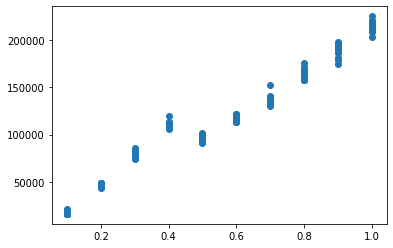

In [325]:
plt.plot(x, y, 'o')

### Fit with given breakpoints
That does obviously not work well and we cannot know those points in advance.

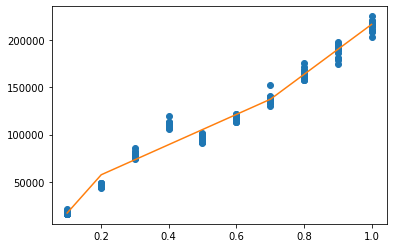

In [326]:
x0 = np.array([min(x), .2, .7, max(x)])

f = pwlf.PiecewiseLinFit(x, y)
f.fit_with_breaks(x0)

xHat = np.linspace(min(x), max(x), num=10000)
yHat = f.predict(xHat)

plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')

In [327]:
p = f.p_values(method='non-linear', step_size=1e-4)
se = f.se
print("p = {}".format(np.around(p, decimals=4)))
print("se = {}".format(np.around(se, decimals=4)))

p = [0. 0. 0. 0. 0. 0.]
se = [0.     0.0002 0.0001 0.0001 0.0001 0.0001]


### Fit with given number of segments

This is more promising. We only need an solution to find the optimal number of segments!

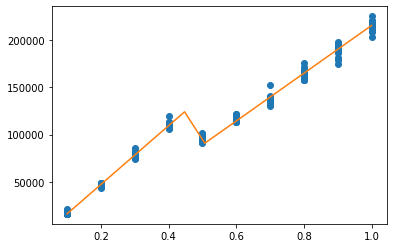

In [332]:
f = pwlf.PiecewiseLinFit(x, y)
f.fit(3)

xHat = np.linspace(min(x), max(x), num=10000)
yHat = f.predict(xHat)

plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')

In [333]:
p = f.p_values(method='non-linear', step_size=1e-4)
se = f.se
print("p = {}".format(np.around(p, decimals=4)))
print("se = {}".format(np.around(se, decimals=4)))


p = [0. 0. 0. 0. 0. 0.]
se = [0.     0.     0.0001 0.0001 0.     0.    ]
